In [2]:
import os, glob, csv
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
# %matplotlib widget
from matplotlib.pylab import size
import sys
sys.path.append(r"D:/5710/MajorProj")  # add the folder to the Python path
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import AutoGate
from IPython.display import clear_output
import time
import shutil
from tqdm import tqdm


from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
import seaborn as sns
import joblib




### Graphical based preprocessing and feature extraction functions

In [3]:
def gray_world_white_balance(img, mask=None):
    """
    Gray-world white balance.
    If a mask is provided, compute averages only within the mask region
    (useful for hand region to avoid background color bias).
    """
    img_f = img.astype(np.float32)
    if mask is not None:
        mask_u8 = (mask > 0).astype(np.uint8)
        avg_b = cv2.mean(img_f[:,:,0], mask_u8)[0]
        avg_g = cv2.mean(img_f[:,:,1], mask_u8)[0]
        avg_r = cv2.mean(img_f[:,:,2], mask_u8)[0]
    else:
        avg_b, avg_g, avg_r = cv2.mean(img_f)[:3]

    avg_gray = (avg_b + avg_g + avg_r) / 3.0
    scale = [
        avg_gray / (avg_b + 1e-6),
        avg_gray / (avg_g + 1e-6),
        avg_gray / (avg_r + 1e-6)
    ]

    img_f[:,:,0] *= scale[0]
    img_f[:,:,1] *= scale[1]
    img_f[:,:,2] *= scale[2]
    return np.clip(img_f, 0, 255).astype(np.uint8)


def adjust_gamma(img, gamma=1.0):
    """
    Apply gamma correction.
    Note: gamma > 1 brightens the image; gamma < 1 darkens it.
    """
    invGamma = 1.0 / max(gamma, 1e-6)
    table = ((np.arange(256) / 255.0) ** invGamma * 255.0).astype(np.uint8)
    return cv2.LUT(img, table)


def clahe_on_l_lab(img_bgr, clip=2.0, tile=(8,8), mask=None):
    """
    Apply CLAHE (local contrast enhancement) on the L channel in Lab color space.
    If a mask is provided, only enhance the masked region (e.g., hand area).
    """
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=float(clip), tileGridSize=tuple(tile))

    if mask is None:
        Lc = clahe.apply(L)
    else:
        Lc_all = clahe.apply(L)
        Lc = L.copy()
        Lc[mask > 0] = Lc_all[mask > 0]

    merged = cv2.merge([Lc, a, b])
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)


def denoise(img):
    """Light denoising using median filter and Non-local Means."""
    img = cv2.medianBlur(img, 3)
    return img


def normalize_hand_image(
    img_bgr,
    mask=None,              # optional binary mask for hand region
    use_hist_eq=False,      # optional global histogram equalization
    use_clahe=True,         # recommended for local contrast enhancement
    clahe_clip=2.0,
    clahe_tile=(12,12),
    auto_gamma=True,
    denoise_after=True
):
    """
    Unified image normalization pipeline for hand gesture preprocessing.

    Steps:
      1. Gray-world white balance 
      2. Adaptive gamma correction 
      3. Optional global histogram equalization
      4. CLAHE on L channel in Lab 
      5. Optional denoising 

    Notes:
      - If both hist_eq and CLAHE are enabled, run CLAHE last.
      - For dark images, gamma > 1.2 brightens them.
      - For bright images, gamma < 1.0 darkens them slightly.
      - If mask is provided, color and contrast are computed only on hand region.
    """
    img = img_bgr.copy()

    # 1) White balance (preferably on hand region only)
    img = gray_world_white_balance(img, mask=mask)

    # 2) Adaptive gamma correction
    if auto_gamma:
        if mask is not None:
            mean_lum = float(cv2.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (mask>0).astype(np.uint8))[0])
        else:
            mean_lum = float(np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

        # empirical thresholds
        if mean_lum < 100:
            gamma = 1.25  # brighten dark images
        elif mean_lum > 170:
            gamma = 0.9   # slightly darken overly bright images
        else:
            gamma = 1.0   # keep as-is

        img = adjust_gamma(img, gamma)

    # 3) Optional global histogram equalization
    if use_hist_eq:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        y_eq = cv2.equalizeHist(y)
        img = cv2.cvtColor(cv2.merge([y_eq, cr, cb]), cv2.COLOR_YCrCb2BGR)

    # 4) CLAHE on L channel
    if use_clahe:
        img = clahe_on_l_lab(img, clip=clahe_clip, tile=clahe_tile, mask=mask)
        img = adjust_gamma(img, gamma=1.3)

    # 5) Optional denoising
    if denoise_after:
        img = denoise(img)

    return img

### Finger constants

In [4]:
# Landmark indices (MediaPipe)
WRIST=0
TH_1, TH_2, TH_3, TH_4 = 1,2,3,4
IN_1, IN_2, IN_3, IN_4 = 5,6,7,8
MI_1, MI_2, MI_3, MI_4 = 9,10,11,12
RI_1, RI_2, RI_3, RI_4 = 13,14,15,16
PI_1, PI_2, PI_3, PI_4 = 17,18,19,20

# Chains (edges) for fingers
FINGERS = [
    [WRIST, TH_1, TH_2, TH_3, TH_4],
    [WRIST, IN_1, IN_2, IN_3, IN_4],
    [WRIST, MI_1, MI_2, MI_3, MI_4],
    [WRIST, RI_1, RI_2, RI_3, RI_4],
    [WRIST, PI_1, PI_2, PI_3, PI_4],
]

EDGES = []
for chain in FINGERS:
    EDGES += list(zip(chain[:-1], chain[1:]))

HAND_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,4),        # thumb
    (0,5), (5,6), (6,7), (7,8),        # index
    (0,9), (9,10), (10,11), (11,12),   # middle
    (0,13), (13,14), (14,15), (15,16), # ring
    (0,17), (17,18), (18,19), (19,20)  # pinky
]



In [5]:
# Helper: display image with correct color handling
def show_image(title, img):
    if img is None:
        print(f"[Warning] {title}: image is None")
        return

    plt.figure(figsize=(6,6))
    # Convert BGR → RGB if color
    if len(img.shape) == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# -------- Utilities --------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def normalize_landmarks_xy(landmarks_xy):
    """Normalize 2D landmarks: make wrist=origin, scale by bbox diagonal for scale invariance."""
    L = landmarks_xy.astype(np.float32).copy()
    wrist = L[0]
    L -= wrist
    minv, maxv = L.min(axis=0), L.max(axis=0)
    diag = float(np.linalg.norm(maxv - minv) + 1e-6)
    L /= diag
    return L

def landmarks_to_feature(landmarks_px_xyz):
    """(21,3): x_px,y_px,z_rel -> 63-D feature: [x',y',z] after 2D normalization."""
    xy_norm = normalize_landmarks_xy(landmarks_px_xyz[:, :2])
    z = landmarks_px_xyz[:, 2:3]
    feat = np.concatenate([xy_norm, z], axis=1).reshape(-1).astype(np.float32)
    return feat  # (63,)

def draw_landmarks_bgr(img_bgr, landmarks_px_xyz):
    mp_draw = mp.solutions.drawing_utils
    mp_style = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands

    # Rebuild normalized list for the drawer
    h, w = img_bgr.shape[:2]
    px, py, pz = (landmarks_px_xyz[:,0] / w), (landmarks_px_xyz[:,1] / h), landmarks_px_xyz[:,2]
    nlms = landmark_pb2.NormalizedLandmarkList(
        landmark=[
            landmark_pb2.NormalizedLandmark(
                x=float(x), y=float(y), z=float(z)
            ) for x, y, z in zip(px, py, pz)
        ]
    )
    out = img_bgr.copy()
    mp_draw.draw_landmarks(
        out, nlms, mp_hands.HAND_CONNECTIONS,
        mp_style.get_default_hand_landmarks_style(),
        mp_style.get_default_hand_connections_style()
    )
    return out


def grabcut_mask_from_landmarks(img_bgr, landmarks_px_xyz, bbox_pad_ratio=0.15, iters=4):
    """Seed GrabCut using a small set of landmark points as sure-foreground; bbox ring as sure-background."""
    h, w = img_bgr.shape[:2]
    # bbox from landmarks
    x1 = int(np.clip(landmarks_px_xyz[:,0].min(), 0, w-1))
    x2 = int(np.clip(landmarks_px_xyz[:,0].max(), 0, w-1))
    y1 = int(np.clip(landmarks_px_xyz[:,1].min(), 0, h-1))
    y2 = int(np.clip(landmarks_px_xyz[:,1].max(), 0, h-1))
    pad = int(bbox_pad_ratio * max(x2 - x1, y2 - y1))
    x1, y1 = max(0, x1 - pad), max(0, y1 - pad)
    x2, y2 = min(w-1, x2 + pad), min(h-1, y2 + pad)

    mask = np.full((h, w), cv2.GC_PR_BGD, np.uint8)
    # sure foreground: wrist + MCPs (robust anchors)
    for idx in [0,5,9,13,17]:
        cx, cy = map(int, landmarks_px_xyz[idx, :2])
        cv2.circle(mask, (cx, cy), 6, cv2.GC_FGD, -1)

    # sure background: a ring outside bbox
    ring = 6
    cv2.rectangle(mask,
                  (max(0, x1 - ring), max(0, y1 - ring)),
                  (min(w-1, x2 + ring), min(h-1, y2 + ring)),
                  cv2.GC_BGD, thickness=ring)

    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    cv2.grabCut(img_bgr, mask, None, bgdModel, fgdModel, iters, cv2.GC_INIT_WITH_MASK)
    hand_mask = np.where((mask==cv2.GC_FGD) | (mask==cv2.GC_PR_FGD), 255, 0).astype('uint8')

    # small cleanup
    hand_mask = cv2.morphologyEx(hand_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    return hand_mask

def process_image_with_mediapipe(input_data, hands,
                                 use_clahe=True, clahe_clip=2.0, clahe_tile=(12,12),
                                 min_short_side=640,        # upscale small images
                                 min_bbox_frac=0.03):       # reject tiny hands
    """
    input_data: can be either
        - str: path to an image file
        - np.ndarray: preloaded BGR image (e.g., from cv2.imread or camera feed)
    """
    # --- Handle input type ---
    if isinstance(input_data, str):
        img_bgr = cv2.imread(input_data)
        if img_bgr is None:
            print(f"[Warning] Cannot read image: {input_data}")
            return None
        img_path = input_data
    elif isinstance(input_data, np.ndarray):
        img_bgr = input_data.copy()
        img_path = "<array_input>"
    else:
        raise ValueError("input_data must be either a file path (str) or an image (np.ndarray)")

    # --- Normalize / preprocess ---
    img_bgr = normalize_hand_image(
        img_bgr,
        use_clahe=use_clahe,
        clahe_clip=clahe_clip,
        clahe_tile=clahe_tile
    )

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_bgr.shape[:2]

    # --- Run MediaPipe Hands ---
    res = hands.process(img_rgb)
    if not res.multi_hand_landmarks:
        return {"img": img_bgr, "n_hands": 0, "img_path": img_path}

    outputs = []
    base_bgr = img_bgr

    # --- Process each detected hand ---
    for i, lms in enumerate(res.multi_hand_landmarks):
        handed_label = res.multi_handedness[i].classification[0].label
        handed_score = res.multi_handedness[i].classification[0].score

        xs = np.array([lm.x for lm in lms.landmark], dtype=np.float32) * w
        ys = np.array([lm.y for lm in lms.landmark], dtype=np.float32) * h
        zs = np.array([lm.z for lm in lms.landmark], dtype=np.float32)
        LM = np.stack([xs, ys, zs], axis=1)

        # Reject small hand boxes
        bw, bh = xs.max()-xs.min(), ys.max()-ys.min()
        if (bw * bh) < (min_bbox_frac * w * h):
            continue

        # Canonicalize left→right
        LM_canon = LM.copy()
        if handed_label == "Left":
            LM_canon[:, 0] = w - LM_canon[:, 0]
            LM_canon[:, 2] *= -1

        feat63 = landmarks_to_feature(LM_canon)

        mask = grabcut_mask_from_landmarks(base_bgr, LM)
        overlay = draw_landmarks_bgr(base_bgr.copy(), LM)

        outputs.append({
            "handed_label": handed_label,
            "handed_score": float(handed_score),
            "landmarks_px_xyz": LM,
            "landmarks_px_xyz_canon": LM_canon,
            "feature63": feat63,
            "mask": mask,
            "overlay": overlay
        })

    return {
        "img": base_bgr,
        "n_hands": len(outputs),
        "hands": outputs,
        "img_path": img_path
    }


# -------- Batch runner --------
def run_folder(input_glob, out_dir="out_mediapipe", max_hands=1, det_conf=0.5):
    ensure_dir(out_dir)
    vis_dir   = ensure_dir(os.path.join(out_dir, "overlay"))
    mask_dir  = ensure_dir(os.path.join(out_dir, "mask"))
    csv_path  = os.path.join(out_dir, "features63.csv")

    mp_hands = mp.solutions.hands
    all_rows = []
    with mp_hands.Hands(static_image_mode=True,
                        max_num_hands=max_hands,
                        min_detection_confidence=det_conf,model_complexity=1) as hands:
        img_paths = sorted(glob.glob(input_glob))
        for p in img_paths:
            r = process_image_with_mediapipe(p, hands)
            if r is None: 
                print(f"[skip] cannot read {p}")
                continue
            if r["n_hands"] == 0:
                print(f"[no hand] {p}")
                continue
            for idx, hinfo in enumerate(r["hands"]):
                base = os.path.splitext(os.path.basename(p))[0]
                savedDir = os.path.join(mask_dir, f"{base}_hand{idx}.png")
                saveLayout = os.path.join(vis_dir, f"{base}_hand{idx}.jpg")
                # save overlay & mask
                cv2.imwrite(saveLayout, hinfo["overlay"])
                cv2.imwrite(savedDir, hinfo["mask"])
                # save feature row
                row = [saveLayout, idx] + hinfo["feature63"].astype(float).tolist()
                all_rows.append(row)

    # write CSV
    header = ["path", "hand_idx"] + [f"f{i:02d}" for i in range(63)]
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f); writer.writerow(header); writer.writerows(all_rows)
    print(f"[done] saved overlays→ {vis_dir}, masks→ {mask_dir}, features→ {csv_path}")


# # # uncomment to run the meidapipe processing on a folder of images
# # # ---------- Run ----------
# base_dir = r"D:/5710/MajorProj/Type_01"
# base_savedir = r"D:/5710/MajorProj/MediaPipeOutput"

# # Loop through all subfolders
# for folder_name in os.listdir(base_dir):
#     subfolder_path = os.path.join(base_dir, folder_name)
#     if not os.path.isdir(subfolder_path):
#         continue  # skip files

#     # Input image pattern (all JPGs)
#     in_pattern = os.path.join(subfolder_path, "*.jpg")

#     # Output directory name pattern: (folder_name)out_mediapipe_(folder_name)
#     out_dir = os.path.join(base_savedir, f"{folder_name}out_mediapipe_{folder_name}")

#     # Make sure the output folder exists
#     os.makedirs(out_dir, exist_ok=True)

#     print(f"Processing folder: {folder_name}")
#     print(f"  Input: {in_pattern}")
#     print(f"  Output: {out_dir}")

#     # Run your function
#     run_folder(in_pattern, out_dir=out_dir, max_hands=1, det_conf=0.8)


### Hand Guesture Normalizer
The Posture reached is required to be normalized and rotated to the standard posture. The following Helper function performs this operation

In [6]:
# ---- Indices (MediaPipe Hands) ----
WRIST = 0
MCP_INDEX, MCP_MIDDLE, MCP_RING, MCP_PINKY = 5, 9, 13, 17
TIP_THUMB = 4
TIP_IDS = [4, 8, 12, 16, 20]  # thumb→pinky tips

# ---- Small helpers ----
def _nz(v, eps=1e-9):
    n = np.linalg.norm(v)
    return v / (n + eps)

def mp_to_camera_frame(L, img_wh=None, assume_normalized=False):
    """x right, y UP, z positive towards camera; centered & roughly unit scale."""
    P = L.astype(np.float32).copy()
    if img_wh is not None and not assume_normalized:
        w, h = float(img_wh[0]), float(img_wh[1])
        s = max(w, h)
        P[:, 0] = (P[:, 0] - w/2.0) / s
        P[:, 1] = (h/2.0 - P[:, 1]) / s    # flip Y and center
    else:
        P[:, 0] = P[:, 0] - 0.5
        P[:, 1] = 0.5 - P[:, 1]
    P[:, 2] = -P[:, 2]                    # closer = positive
    return P


def kabsch(A, B, with_scale=False):
    """Align A->B via rigid (or similarity) transform; returns (R, t, s)."""
    A = A.astype(np.float32); B = B.astype(np.float32)
    cA, cB = A.mean(0), B.mean(0)
    A0, B0 = A - cA, B - cB
    if with_scale:
        sA = np.sqrt((A0**2).sum()/A.shape[0]) + 1e-9
        sB = np.sqrt((B0**2).sum()/A.shape[0]) + 1e-9
        A0 /= sA; B0 /= sB
    H = A0.T @ B0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    s = 1.0
    if with_scale:
        s = (S.sum() / (A0**2).sum())
    t = cB - (s * (R @ cA))
    return R.astype(np.float32), t.astype(np.float32), float(s)

# ---- Your upgraded normalizer ----
def normalize_hand_orientation(
    landmarks,
    img_wh=None,
    assume_normalized_xy=False,
    method="basis",            # 'basis' (fast) or 'kabsch' (template)
    template=None,             # (21,3) template in camera frame if method='kabsch'
    kabsch_with_scale=False,   # use similarity instead of pure rigid
    mirror_thumb=True          # enforce thumb on +X
):
    """
    Input:
      landmarks: (21,3) from MediaPipe (x,y in px or [0..1], z relative).
      img_wh: (W,H) if landmarks are in pixels (recommended).
      assume_normalized_xy: set True if x,y already in [0..1].
      method: 'basis' (default) or 'kabsch'.
      template: required if method='kabsch'; reference (21,3) in camera frame.
    Returns:
      Lc: (21,3) canonicalized (wrist@origin, scaled, 'pointing up', thumb on +X).
      info: dict with 'R' (3x3), 't' (3,), 'scale' (float), and 'method'.
    """

    assert landmarks.shape == (21, 3)
    # 0) Convert to right-handed camera frame
    P = mp_to_camera_frame(landmarks, img_wh=img_wh, assume_normalized=assume_normalized_xy)
    # 1) Translate to wrist origin
    P -= P[WRIST]
    # 2) Scale by wrist->middle-MCP (robust hand size)
    hand_size = np.linalg.norm(P[MCP_MIDDLE]) or 1.0
    P /= hand_size

    R = np.eye(3, dtype=np.float32)
    t = np.zeros(3, dtype=np.float32)
    s = 1.0

    if method == "basis":
        # --- Orthonormal hand basis ---
        v = _nz(P[MCP_MIDDLE])  # desired +Y
        u = _nz((P[MCP_INDEX] - P[WRIST]) - (P[MCP_PINKY] - P[WRIST]))  # desired +X
        w = _nz(np.cross(u, v))  # desired +Z
        u = _nz(np.cross(v, w))  # re-orthogonalize
        B = np.stack([u, v, w], axis=1)  # columns are axes
        Lc = P @ B                       # rotate into canonical (u,v,w)
        R = B
    else:
        # --- Kabsch alignment to template ---
        assert template is not None and template.shape == (21,3), \
            "Provide a (21,3) template in camera frame for method='kabsch'."

        # Ensure template is wrist-centered and comparable scale
        T = template.astype(np.float32).copy()
        T -= T[WRIST]
        Ts = np.linalg.norm(T[MCP_MIDDLE]) or 1.0
        T /= Ts

        IDX = [WRIST, MCP_INDEX, MCP_MIDDLE, MCP_RING, MCP_PINKY]
        Rk, tk, sk = kabsch(P[IDX], T[IDX], with_scale=kabsch_with_scale)
        Lc = (sk * (P @ Rk.T)) + tk
        R, t, s = Rk, tk, sk

    # 3) Mirror so thumb is on +X (consistent handedness)
    if mirror_thumb and Lc[TIP_THUMB, 0] < 0:
        Lc[:, 0] *= -1.0
        R[:, 0] *= -1.0  # reflect basis X to keep R consistent

    info = {"R": R, "t": t, "scale": s * (1.0/hand_size), "method": method}
    return Lc, info

### Perform the preprocessing 

In [7]:

def get_proximal_phalange_lengths(L):
    """
    Compute normalized proximal phalange lengths for each finger.
    L : (21,3) landmark array (after normalization).
    Returns dict with one length per finger.
    """
    # Indices per finger (MediaPipe)
    WRIST = 0
    MCP = [5, 9, 13, 17]   # base of each finger (Index–Pinky)
    PIP = [6, 10, 14, 18]  # next joint up

    lengths = {}
    for name, mcp, pip in zip(["Index", "Middle", "Ring", "Pinky"], MCP, PIP):
        lengths[name] = float(np.linalg.norm(L[pip] - L[mcp]))
    # Thumb: use 1→2 (MCP→IP)
    lengths["Thumb"] = float(np.linalg.norm(L[2] - L[1]))
    return lengths

def get_middle_phalange_lengths(L):
    """
    Compute normalized middle phalange lengths for each finger.
    L : (21,3) landmark array (after normalization).
    Returns dict with one length per finger.
    """
    # indices for middle phalanges (PIP→DIP)
    FINGERS = {
        "Thumb": (2, 4),    # IP→Tip
        "Index": (6, 7),    # PIP→DIP
        "Middle": (10, 11),
        "Ring": (14, 15),
        "Pinky": (18, 19)
    }

    lengths = {}
    for name, (a, b) in FINGERS.items():
        lengths[name] = float(np.linalg.norm(L[b] - L[a]))
    return lengths


def joint_distance(L, i, j):
    """
    Compute the Euclidean distance between two joints in a (21,3) landmark array.
    L : np.ndarray of shape (21,3)
    i, j : joint indices (e.g., 0=wrist, 9=middle MCP, etc.)
    Returns: distance (float)
    """
    assert L.shape == (21, 3), "Input must be (21,3) landmarks."
    p1, p2 = L[i], L[j]
    dist = np.linalg.norm(p1 - p2)
    print(f"Distance between joint {i} and {j}: {dist:.5f}")
    return dist


def mp_to_camera_frame(L, img_wh=None, assume_normalized=False):
    """
    Convert MediaPipe landmarks to a right-handed camera frame for plotting.
    MediaPipe: x right, y DOWN, z negative = closer.
    Output:    x right, y UP,   z positive = closer.

    L : (21,3) array in pixels (if img_wh given) or normalized [0,1] (if assume_normalized=True).
    img_wh : (w,h) if L is in pixels.
    """
    P = L.astype(np.float32).copy()

    if img_wh is not None and not assume_normalized:
        w, h = float(img_wh[0]), float(img_wh[1])
        s = max(w, h)  # isotropic scale, keeps aspect
        # centre to (0,0) and scale to ~[-0.5,0.5]
        P[:, 0] = (P[:, 0] - w/2.0) / s
        P[:, 1] = (h/2.0 - P[:, 1]) / s   # flip Y (down->up) and centre
    else:
        # normalized [0,1] -> centre to 0 and flip Y
        P[:, 0] = P[:, 0] - 0.5
        P[:, 1] = 0.5 - P[:, 1]           # flip Y

    P[:, 2] = -P[:, 2]                    # make positive Z = closer
    return P

def plot_hand_3d_fixed(L, img_wh=None, assume_normalized=False,
                       title="Hand (right-handed camera frame)",
                       elev=20, azim=120, save_path=None):
    """
    L : (21,3) MediaPipe landmarks (pixels or normalized).
    img_wh : (w,h) if L is in pixels; else None.
    assume_normalized : True if L[:,0:2] are in [0,1].
    """
    assert L.shape == (21,3), "Expected (21,3) landmarks."

    P = mp_to_camera_frame(L, img_wh=img_wh, assume_normalized=assume_normalized)
    xs, ys, zs = P[:,0], P[:,1], P[:,2]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)

    # --- show phalange lengths ---
    lengths = get_proximal_phalange_lengths(L)
    print("\n--- Normalized proximal phalange lengths ---")
    for finger, val in lengths.items():
        print(f"{finger:<7s}: {val:.4f}")

    print("\n--- Normalized middle phalange lengths ---")
    mid_lengths = get_middle_phalange_lengths(L)
    for finger, val in mid_lengths.items():
        print(f"{finger:<7s}: {val:.4f}")

    # --- plot bones ---
    for i, j in HAND_CONNECTIONS:
        ax.plot([xs[i], xs[j]], [ys[i], ys[j]], [zs[i], zs[j]], lw=2)

    # --- plot joints and labels ---
    ax.scatter(xs, ys, zs, c='r', s=40)
    for idx in range(len(xs)):
        ax.text(xs[idx], ys[idx], zs[idx],
                f"{idx}", color='black', fontsize=8, ha='center')

    # mark wrist clearly
    ax.text(xs[0], ys[0], zs[0], "Wrist", color='blue', fontsize=9, fontweight='bold')

    # --- set axis and limits ---
    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.8, 0.8)
    ax.set_zlim(-0.8, 0.8)
    ax.set_box_aspect([1,1,1])
    ax.set_xlabel("X (right)")
    ax.set_ylabel("Y (up)")
    ax.set_zlabel("Z (towards camera)")

    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()




# --- 1  Source & destination paths ---
src_root = r"D:/5710/MajorProj/MediaPipeOutput"
dst_root = r"D:/5710/MajorProj/NormalizedOutput"

# --- 2  Find all subfolder CSVs ---
csv_files = glob.glob(os.path.join(src_root, "*", "features63.csv"))
print(f"Found {len(csv_files)} folders to process.")

# --- 3  Utility functions ---


def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

def mirror_and_save(Lc, src_img_path, out_root, class_name):
    """
    Save normalized image + 63D CSV row to mirrored subfolder.
    class_name may look like 'Aout_mediapipe_A' — we only keep 'A'.
    """
    # --- clean class_name ---
    # keep the part AFTER the last occurrence of '_mediapipe_'
    if "_mediapipe_" in class_name:
        class_name = class_name.split("_mediapipe_")[-1]

    # proceed as before
    base = os.path.splitext(os.path.basename(src_img_path))[0]
    out_dir = ensure_dir(os.path.join(out_root, class_name))
    out_img_dir = ensure_dir(os.path.join(out_dir, "images"))
    out_csv = os.path.join(out_dir, "features63_normalized.csv")

    # --- copy image ---
    dst_img = os.path.join(out_img_dir, f"{base}_norm.jpg")
    img = cv2.imread(src_img_path)
    if img is not None:
        cv2.imwrite(dst_img, img)

    # --- flatten 63 features and append to CSV ---
    feat = Lc.reshape(-1).astype(float).tolist()
    header = ["path"] + [f"f{i:02d}" for i in range(63)]
    row = [dst_img] + feat

    new_file = not os.path.exists(out_csv)
    with open(out_csv, "a", newline="") as f:
        import csv
        writer = csv.writer(f)
        if new_file:
            writer.writerow(header)
        writer.writerow(row)

    return dst_img, out_csv




# # --- 4  Process each CSV file ---
# overall_total = 0
# overall_rejected = 0
# overall_accepted = 0

# for csv_path in tqdm(csv_files, desc="Processing folders"):
#     gate = AutoGate.RANSACRejectionGate(
#         win=512, ransac_iters=60, ransac_thresh=0.06,
#         k_score=3.0, close_ratio=0.04, min_inliers=4,
#         template_palm=None
#     )

#     class_name = os.path.basename(os.path.dirname(csv_path))
#     df = pd.read_csv(csv_path)

#     X = df.loc[:, "f00":"f62"].to_numpy(dtype=np.float32)
#     FileNames = df["path"].to_numpy()
#     print(f"\n[{class_name}] → {len(X)} samples")

#     total = len(X)
#     accepted = 0
#     rejected = 0

#     for i, sample in enumerate(X):
#         L = sample.reshape((21, 3))
#         Lc, info = normalize_hand_orientation(L, method="basis",
#                                               kabsch_with_scale=True,
#                                               mirror_thumb=True)
#         z_zoomfactor = 2.5
#         Lc[:, 0] *= z_zoomfactor

#         is_ok = gate.is_valid(Lc)
#         if not is_ok:
#             rejected += 1
#             continue
#         accepted += 1
#         mirror_and_save(Lc, FileNames[i], dst_root, class_name)

#     # class summary
#     acc_rate = accepted / total if total else 0
#     rej_rate = rejected / total if total else 0
#     print(f"[{class_name}] accepted={accepted}  rejected={rejected}  "
#           f"accept_rate={acc_rate:.3f}  reject_rate={rej_rate:.3f}")

#     # accumulate global stats
#     overall_total += total
#     overall_accepted += accepted
#     overall_rejected += rejected

# # ---- final overall summary ----
# if overall_total > 0:
#     overall_acc_rate = overall_accepted / overall_total
#     overall_rej_rate = overall_rejected / overall_total
#     print("\n===== Overall Summary =====")
#     print(f"Total samples     : {overall_total}")
#     print(f"Accepted samples  : {overall_accepted}")
#     print(f"Rejected samples  : {overall_rejected}")
#     print(f"Acceptance rate   : {overall_acc_rate:.3%}")
#     print(f"Rejection rate    : {overall_rej_rate:.3%}")
# else:
#     print("No samples processed.")





Found 29 folders to process.


### Data preparation and feature extraction

In [8]:
import os, glob, re
import numpy as np
import pandas as pd
import cv2

# =========================
# Config
# =========================
BASE_FOLDER   = r"D:/5710/MajorProj"
NORM_ROOT     = os.path.join(BASE_FOLDER, "NormalizedOutput")  # where features63_normalized.csv live (per class)
TYPE01_ROOT   = os.path.join(BASE_FOLDER, "Type_01")          # original images root by class (A,B,C,...)
OUT_CSV       = os.path.join(NORM_ROOT, "combined_features.csv")
POSSIBLE_EXTS = [".jpg", ".png", ".jpeg", ".JPG", ".PNG", ".JPEG"]


# =========================
# Hand topology / helpers
# =========================
# MediaPipe Hands indices
WRIST = 0
MCP_INDEX, MCP_MIDDLE, MCP_RING, MCP_PINKY = 5, 9, 13, 17
TIP_THUMB, TIP_INDEX, TIP_MIDDLE, TIP_RING, TIP_PINKY = 4, 8, 12, 16, 20

# Edges for bone-length features (21 joints)
EDGES = [
    (0,1),(1,2),(2,3),(3,4),          # thumb
    (0,5),(5,6),(6,7),(7,8),          # index
    (0,9),(9,10),(10,11),(11,12),     # middle
    (0,13),(13,14),(14,15),(15,16),   # ring
    (0,17),(17,18),(18,19),(19,20)    # pinky
]

FINGER_CHAINS = {
    "thumb":  [0,1,2,3,4],
    "index":  [0,5,6,7,8],
    "middle": [0,9,10,11,12],
    "ring":   [0,13,14,15,16],
    "pinky":  [0,17,18,19,20],
}

def _angle(u, v, eps=1e-9):
    """Angle between u and v in radians."""
    nu = np.linalg.norm(u) + eps
    nv = np.linalg.norm(v) + eps
    cos = np.clip(np.dot(u, v) / (nu * nv), -1.0, 1.0)
    return float(np.arccos(cos))

def _palm_quad_area_2d(L21x3):
    """Area from MCP quad (index, middle, ring, pinky) using XY only."""
    A = L21x3[[MCP_INDEX, MCP_MIDDLE, MCP_RING, MCP_PINKY], :2]
    # shoelace
    x, y = A[:,0], A[:,1]
    return 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))

def _joint_angles(L21x3):
    """
    Per-finger joint angles at MCP/PIP/DIP (thumb has CMC/MCP/IP).
    Returns dict of angles (radians).
    """
    ang = {}
    for name, chain in FINGER_CHAINS.items():
        # segments: wrist->1, 1->2, 2->3, 3->tip
        pts = L21x3[chain]
        v01 = pts[1] - pts[0]
        v12 = pts[2] - pts[1]
        v23 = pts[3] - pts[2]
        v34 = pts[4] - pts[3]
        # internal angles at joints 1,2,3 using incoming/outgoing vectors
        a1 = _angle(-v01, v12)  # joint at node 1
        a2 = _angle(-v12, v23)  # joint at node 2
        a3 = _angle(-v23, v34)  # joint at node 3
        ang[f"{name}_j1"] = a1
        ang[f"{name}_j2"] = a2
        ang[f"{name}_j3"] = a3
    return ang

def _spread_measures(L21x3):
    """
    Finger-spread metrics using MCP points in XY (scale-invariant if your L21x3 is normalized).
    """
    P = L21x3
    mcp = P[[MCP_INDEX, MCP_MIDDLE, MCP_RING, MCP_PINKY], :2]
    d_idx_mid   = np.linalg.norm(mcp[1] - mcp[0])
    d_mid_ring  = np.linalg.norm(mcp[2] - mcp[1])
    d_ring_pink = np.linalg.norm(mcp[3] - mcp[2])
    return {
        "spread_idx_mid":   float(d_idx_mid),
        "spread_mid_ring":  float(d_mid_ring),
        "spread_ring_pink": float(d_ring_pink),
    }


# =========================
# Image-only features (global; ROI-free)
# =========================

def _img_features(img_bgr):
    """
    Image-level stats that do not need the hand ROI:
      - brightness mean/std (gray)
      - Laplacian variance (sharpness)
      - edges density (Canny on gray)
      - HSV means/stds
    """
    feats = {}
    if img_bgr is None or img_bgr.size == 0:
        # NaNs to make it obvious we couldn't read the image
        for k in [
            "lap_var","edge_density"
        ]:
            feats[f"img_{k}"] = np.nan
        return feats

    h, w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Sharpness
    feats["img_lap_var"] = float(cv2.Laplacian(gray, cv2.CV_64F).var())

    # Edge density (Canny thresholds tied to median)
    med = np.median(gray)
    low = int(max(0, 0.66 * med))
    high = int(min(255, 1.33 * med))
    edges = cv2.Canny(gray, low, high)
    feats["img_edge_density"] = float((edges > 0).mean())

    return feats


# =========================
# FeatureCombiner
# =========================

class FeatureCombiner:
    """
    Receives:
      - img_bgr: original image (OpenCV BGR)
      - feat63:  (63,) flattened [x,y,z]*21  (typically canonical/normalized in your pipeline)
    Returns:
      dict of features (geometry + image stats).
    """
    def __init__(self, include_original63=False):
        self.include_original63 = include_original63

    def compute(self, img_bgr, feat63):
        out = {}

        # 1) unpack landmarks
        L = np.asarray(feat63, dtype=np.float32).reshape(21, 3)  # normalized/canonical in your pipeline

        # 2) geometry features (scale-invariant on normalized L)

        #    b) joint angles per finger (MCP/PIP/DIP)
        ang = _joint_angles(L)
        for k, v in ang.items():
            out[f"geo_angle_{k}"] = float(v)

        #    c) palm area + spread
        out["geo_palm_area"] = float(_palm_quad_area_2d(L))
        spread = _spread_measures(L)
        for k, v in spread.items():
            out[f"geo_{k}"] = float(v)

        #    d) z-shape stats
        z = L[:, 2]
        out["geo_z_mean"] = float(np.mean(z))
        out["geo_z_std"]  = float(np.std(z))
        out["geo_z_min"]  = float(np.min(z))
        out["geo_z_max"]  = float(np.max(z))
        out["geo_z_rng"]  = out["geo_z_max"] - out["geo_z_min"]

        # 3) image features (global)
        out.update(_img_features(img_bgr))

        # 4) (optional) keep the raw 63D for traceability (prefix 'raw_')
        if self.include_original63:
            for i, val in enumerate(np.asarray(feat63, dtype=np.float32).ravel()):
                out[f"raw_f{i:02d}"] = float(val)

        return out





### CSV reader and saver with Training data

In [9]:
# =========================
# CSV utilities  +  Build the training-test dataset
# =========================
def load_per_class_csvs(norm_root):
    """
    Finds all subfolders under norm_root and loads 'features63_normalized.csv' if present.
    Returns list of (class_name, DataFrame, csv_path, class_dir).
    """
    bundles = []
    for cdir in sorted(glob.glob(os.path.join(norm_root, "*"))):
        if not os.path.isdir(cdir):
            continue
        cname = os.path.basename(cdir)
        csv_path = os.path.join(cdir, "features63_normalized.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            bundles.append((cname, df, csv_path, cdir))
    return bundles

def find_original_image_path(stored_path, class_name):
    """
    Try to reconstruct the original image path in Type_01/class_name/<token>.<ext>
    from a saved overlay/normalized path that contains '<class>_<id>_hand0.ext'.
    """
    fname = os.path.basename(stored_path)
    m = re.match(rf"({class_name}_[0-9]+)_hand\d+\.[^.]+$", fname, flags=re.IGNORECASE)
    if m:
        token = m.group(1)
    else:
        # fallback: strip trailing '_hand...' if present
        stem, _ = os.path.splitext(fname)
        token = stem.split("_hand")[0]

    # Try all common extensions
    for ext in POSSIBLE_EXTS:
        candidate = os.path.join(TYPE01_ROOT, class_name, token + ext)
        if os.path.exists(candidate):
            return candidate
    # if nothing exists, return best guess (jpg) so we at least write something
    return os.path.join(TYPE01_ROOT, class_name, token + ".jpg")


# =========================
# Main: combine features -> CSV
# =========================
def main():
    combiner = FeatureCombiner(include_original63=False)
    bundles = load_per_class_csvs(NORM_ROOT)
    if not bundles:
        print(f"[error] No per-class normalized CSVs found under: {NORM_ROOT}")
        return

    rows_out = []
    for class_name, df, _, _ in bundles:
        # Expect "path" + f00..f62
        if "path" not in df.columns:
            print(f"[warn] 'path' missing in {class_name} CSV — skipping class")
            continue

        # iterate rows
        for idx, row in df.iterrows():
            stored_path = row["path"]
            # recover original image
            orig_path = find_original_image_path(stored_path, class_name)
            img = cv2.imread(orig_path)

            # extract the 63-D feature vector (from f00..f62 or raw_f00..f62)
            if "f00" in row.index:
                feat = np.array([row[f"f{j:02d}"] for j in range(63)], dtype=np.float32)
            elif "raw_f00" in row.index:
                feat = np.array([row[f"raw_f{j:02d}"] for j in range(63)], dtype=np.float32)
            else:
                # try to auto-detect
                fcols = [c for c in row.index if re.fullmatch(r"(raw_)?f\d{2}", c)]
                fcols = sorted(fcols, key=lambda x: int(re.findall(r"\d{2}", x)[0]))
                feat = row[fcols].to_numpy(np.float32)
                if feat.size != 63:
                    print(f"[warn] row {idx} in {class_name}: cannot find 63-D vector; skip")
                    continue

            # compute combined features
            feats = combiner.compute(img, feat)

            # make output record
            rec = {
                "original_path": orig_path,
                "class": class_name,
            }
            rec.update(feats)
            rows_out.append(rec)

    if not rows_out:
        print("[warn] no rows produced.")
        return

    out_df = pd.DataFrame(rows_out)
    # Nice ordering: front-matter, raw_63 (optional), then geo/img features
    front_cols = ["original_path", "class"]
    raw_cols   = [c for c in out_df.columns if c.startswith("raw_f")]
    geo_cols   = sorted([c for c in out_df.columns if c.startswith("geo_")])
    img_cols   = sorted([c for c in out_df.columns if c.startswith("img_")])

    ordered = front_cols + raw_cols + geo_cols + img_cols
    # keep any leftover columns (unlikely) at the end
    ordered += [c for c in out_df.columns if c not in ordered]

    out_df = out_df[ordered]
    os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
    out_df.to_csv(OUT_CSV, index=False)
    print(f"[done] wrote {len(out_df)} rows → {OUT_CSV}")


# if __name__ == "__main__":
#     main()


### Train the Knn and SVM Models



 Overall Cross-Validated Accuracy: 99.93%

--- Classification Report ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       881
           B       1.00      1.00      1.00      2689
           C       1.00      1.00      1.00       669
           D       1.00      1.00      1.00      2827
         DEL       1.00      1.00      1.00      3911
           E       1.00      1.00      1.00      1189
           F       1.00      1.00      1.00      3649
           G       1.00      0.99      1.00      2265
           H       1.00      1.00      1.00      2352
           I       1.00      1.00      1.00      3085
           J       1.00      1.00      1.00      2976
           K       1.00      1.00      1.00      2660
           L       1.00      1.00      1.00      3240
           M       1.00      1.00      1.00       405
           N       1.00      0.99      1.00       144
           O       1.00      1.00      1.00       675
       

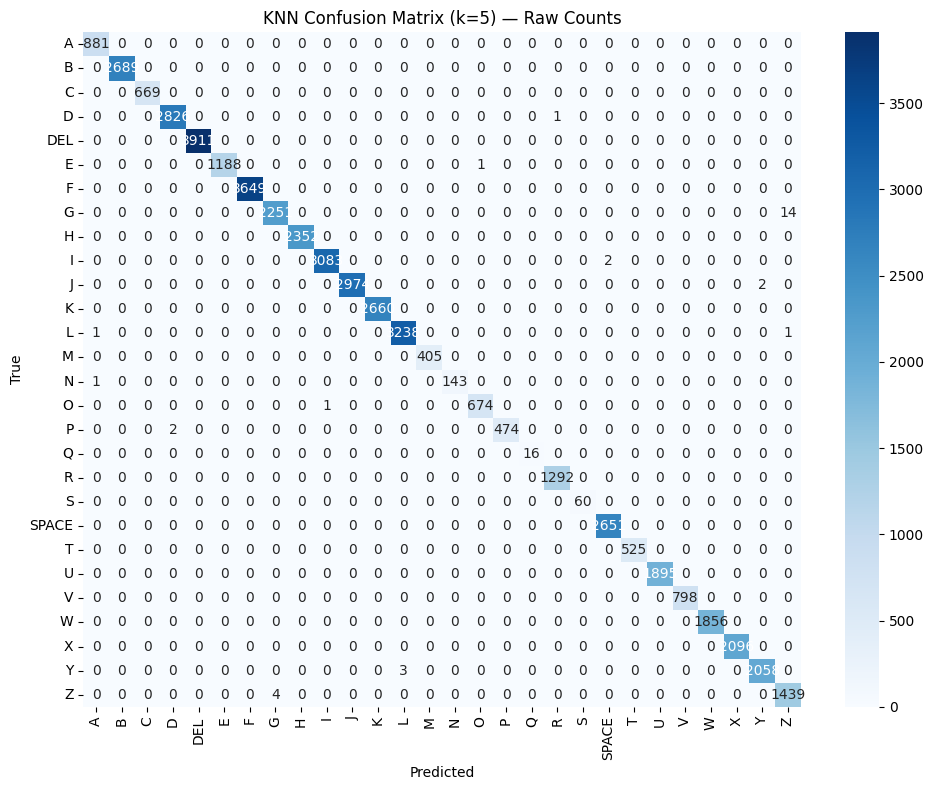

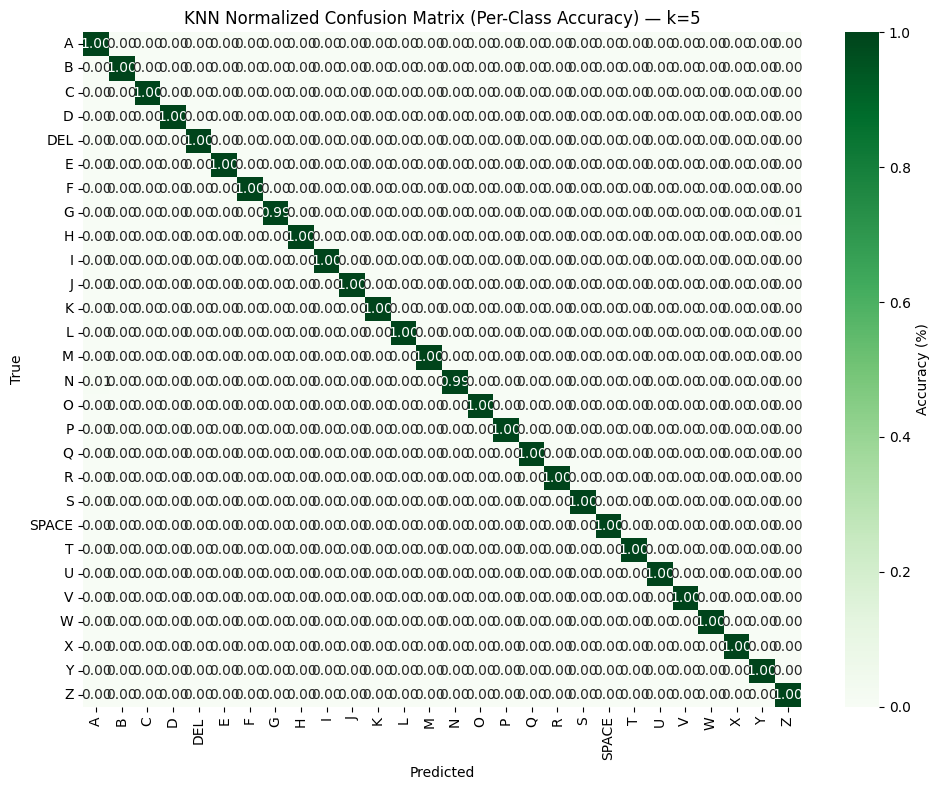

A        → 100.00%
B        → 100.00%
C        → 100.00%
D        → 99.96%
DEL      → 100.00%
E        → 99.92%
F        → 100.00%
G        → 99.38%
H        → 100.00%
I        → 99.94%
J        → 99.93%
K        → 100.00%
L        → 99.94%
M        → 100.00%
N        → 99.31%
O        → 99.85%
P        → 99.58%
Q        → 100.00%
R        → 100.00%
S        → 100.00%
SPACE    → 100.00%
T        → 100.00%
U        → 100.00%
V        → 100.00%
W        → 100.00%
X        → 100.00%
Y        → 99.85%
Z        → 99.72%

Mean class accuracy: 99.91%


In [10]:
# ============ CONFIG ============
csv_path = r"D:/5710/MajorProj/NormalizedOutput/combined_features.csv"
k_neighbors = 5
cv_folds = 5
random_state = 42

# ============ LOAD DATA ============
df = pd.read_csv(csv_path).dropna()
X = df.drop(columns=["original_path", "class"]).select_dtypes(include=[np.number]).values
y = df["class"].values

# # ============ MODEL- KNN============
# pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k_neighbors))
# cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# # Out-of-fold predictions for full confusion matrix
# y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)
# pipe.fit(X, y)
    
# joblib.dump(pipe, r"D:/5710/MajorProj/Models/knn_model.pkl")


#=========== MODEL- SVM ============
# --- model: Standardize → SVM(RBF) ---
pipe = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=10.0, gamma="scale", class_weight=None, random_state=random_state)
)

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)
pipe.fit(X, y)


joblib.dump(pipe, r"D:/5710/MajorProj/Models/svm_model.pkl")

#=========== Accuracy ============

# Accuracy (overall)
acc = accuracy_score(y, y_pred)
print(f"\n Overall Cross-Validated Accuracy: {acc*100:.2f}%")

# Detailed report
print("\n--- Classification Report ---")
print(classification_report(y, y_pred))



# ============ CONFUSION MATRICES ============
labels = np.unique(y)
cm = confusion_matrix(y, y_pred, labels=labels)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# --- Plot raw confusion matrix ---
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"KNN Confusion Matrix (k={k_neighbors}) — Raw Counts")
plt.tight_layout()
plt.show()

# --- Plot normalized accuracy matrix ---
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Accuracy (%)'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"KNN Normalized Confusion Matrix (Per-Class Accuracy) — k={k_neighbors}")
plt.tight_layout()
plt.show()

# Optional: show mean class accuracy
class_acc = np.diag(cm_norm)
for lbl, acc in zip(labels, class_acc):
    print(f"{lbl:<8s} → {acc*100:.2f}%")
print(f"\nMean class accuracy: {class_acc.mean()*100:.2f}%")


In [11]:
    import cv2
    import mediapipe as mp

    img = cv2.imread("D:/5710/MajorProj/Type_01/B/B_1128.jpg")
    combiner = FeatureCombiner(include_original63=False)

    mp_hands = mp.solutions.hands
    row = []
    with mp_hands.Hands(static_image_mode=True,
                        max_num_hands=1,
                        min_detection_confidence=0.8,model_complexity=1) as hands:
        r = process_image_with_mediapipe(img, hands)
        if r is None:
            print(f"[skip] cannot read ")
        if r["n_hands"] == 0:
            print(f"[no hand]")
        for idx, hinfo in enumerate(r["hands"]):
            row = np.array(hinfo["feature63"], dtype=np.float32)
            # Now reshape safely
            L = row.reshape((21, 3))
            Lc, info = normalize_hand_orientation(
                L,
                method="basis",
                kabsch_with_scale=True,
                mirror_thumb=True
            )
            z_zoomfactor = 2.5
            Lc[:, 0] *= z_zoomfactor
            print(Lc)

    FEATURE_ORDER = [
        "geo_angle_index_j1", "geo_angle_index_j2", "geo_angle_index_j3",
        "geo_angle_middle_j1", "geo_angle_middle_j2", "geo_angle_middle_j3",
        "geo_angle_pinky_j1", "geo_angle_pinky_j2", "geo_angle_pinky_j3",
        "geo_angle_ring_j1", "geo_angle_ring_j2", "geo_angle_ring_j3",
        "geo_angle_thumb_j1", "geo_angle_thumb_j2", "geo_angle_thumb_j3",
        "geo_palm_area",
        "geo_spread_idx_mid", "geo_spread_mid_ring", "geo_spread_ring_pink",
        "geo_z_max", "geo_z_mean", "geo_z_min", "geo_z_rng", "geo_z_std",
        "img_edge_density", "img_lap_var"
    ]

    # --- compute features as usual ---
    feats = combiner.compute(img, Lc)

    # --- reorder & convert ---
    feat_vec = np.array([feats.get(k, np.nan) for k in FEATURE_ORDER], dtype=np.float32).reshape(1, -1)


    svm_model = joblib.load(r"D:/5710/MajorProj/Models/svm_model.pkl")
    X_test = np.array([list(feat_vec.flatten())], dtype=np.float32)
    y_pred = svm_model.predict(X_test)
    print(f"Predicted class: {y_pred[0]}")

[[-0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.57272899e-01  1.57362536e-01  1.50119379e-01]
 [-1.00857675e+00  5.37591338e-01  1.61746696e-01]
 [-5.62645376e-01  8.10968041e-01  1.56580776e-01]
 [ 7.18581527e-02  8.23536992e-01  1.80374473e-01]
 [-5.53417504e-01  1.00279820e+00  2.32939459e-02]
 [-4.81227458e-01  1.39138436e+00  5.68792596e-02]
 [-3.77052993e-01  1.64272678e+00  1.02826506e-01]
 [-2.30198294e-01  1.84768140e+00  1.36643365e-01]
 [-8.78760886e-09  1.00000000e+00 -1.98279970e-09]
 [ 6.29515350e-02  1.41426897e+00  2.28089914e-02]
 [ 1.42871469e-01  1.70219958e+00  6.65310845e-02]
 [ 2.48751923e-01  1.94870460e+00  9.39969346e-02]
 [ 4.98316318e-01  9.16799426e-01  5.00417489e-04]
 [ 6.01466656e-01  1.29930258e+00  2.33693402e-02]
 [ 5.97572446e-01  1.55906379e+00  5.12402430e-02]
 [ 6.11750424e-01  1.77280951e+00  6.64810538e-02]
 [ 1.02294457e+00  7.64397323e-01  2.32939422e-02]
 [ 1.10929775e+00  1.05149031e+00  4.96304557e-02]
 [ 1.08550942e+00  1.24248314e+

Detected classes: ['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total images: 4718, skipped: 0, no-hand: 668, used: 4050
Saved predictions to: D:\5710\MajorProj\eval_predictions.csv

Classification report:
              precision    recall  f1-score   support

           A       0.63      0.97      0.77       187
           B       0.88      0.99      0.93       199
           C       0.91      0.87      0.89       140
           D       0.62      1.00      0.76       165
         DEL       0.90      0.97      0.93       236
           E       1.00      0.60      0.75       193
           F       0.96      0.85      0.90       126
           G       0.19      0.72      0.30        85
           H       0.00      0.00      0.00       153
           I       0.71      0.98      0.82       139
           J       0.25      0.79      0.38        67
           K       0.74      0.63      0.68      

C:\Users\Lyn20\AppData\Local\Temp\ipykernel_18228\3924136714.py:145: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Saved raw confusion matrix to: D:\5710\MajorProj\confusion_matrix_svm_raw.png


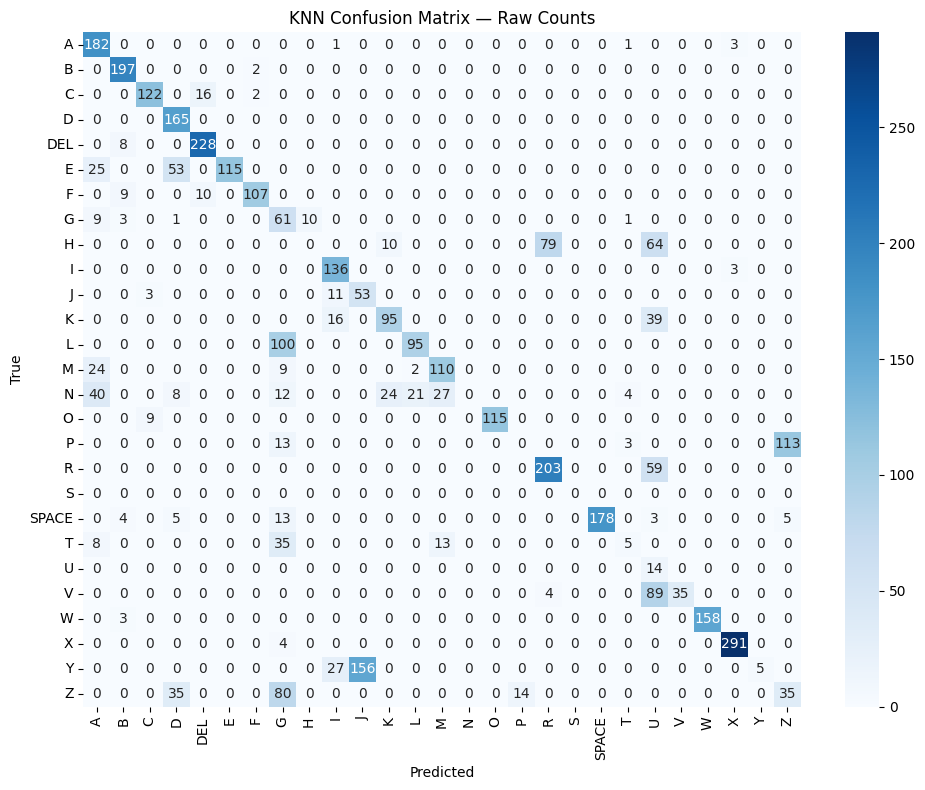

Saved normalized confusion matrix to: D:\5710\MajorProj\confusion_matrix_svm_norm.png


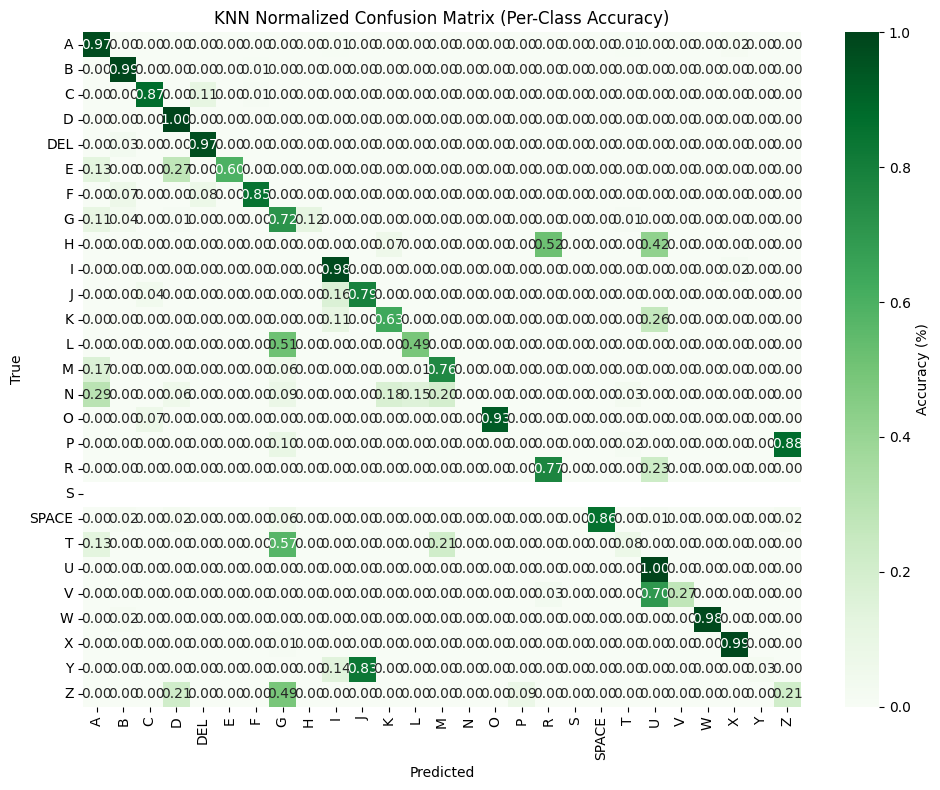

A        → 97.33%
B        → 98.99%
C        → 87.14%
D        → 100.00%
DEL      → 96.61%
E        → 59.59%
F        → 84.92%
G        → 71.76%
H        → 0.00%
I        → 97.84%
J        → 79.10%
K        → 63.33%
L        → 48.72%
M        → 75.86%
N        → 0.00%
O        → 92.74%
P        → 0.00%
R        → 77.48%
S        → nan%
SPACE    → 85.58%
T        → 8.20%
U        → 100.00%
V        → 27.34%
W        → 98.14%
X        → 98.64%
Y        → 2.66%
Z        → 21.34%

Mean class accuracy: nan%


: 

In [ ]:
    # run_eval_svm.py
    import os, sys, glob
    from pathlib import Path
    import cv2
    import numpy as np
    import joblib
    import mediapipe as mp
    from sklearn.metrics import confusion_matrix, classification_report
    import matplotlib.pyplot as plt

    # (Optional) prettier CM
    try:
        import seaborn as sns
        USE_SEABORN = True
    except Exception:
        USE_SEABORN = False

    # ====== IMPORT YOUR OWN HELPERS ======
    # Make sure these imports match your project structure
    # e.g., from mypkg.features import FeatureCombiner
    # ====== PATHS ======
    TEST_ROOT = Path(r"D:/5710/MajorProj/test")           # test root with class subfolders A, B, C, D, ...
    MODEL_PATH = Path(r"D:/5710/MajorProj/Models/knn_model.pkl")
    OUT_CSV = Path(r"D:/5710/MajorProj/eval_predictions.csv")
    CM_PNG = Path(r"D:/5710/MajorProj/confusion_matrix.png")

    # ====== FEATURE ORDER (must match training) ======
    FEATURE_ORDER = [
        "geo_angle_index_j1", "geo_angle_index_j2", "geo_angle_index_j3",
        "geo_angle_middle_j1", "geo_angle_middle_j2", "geo_angle_middle_j3",
        "geo_angle_pinky_j1", "geo_angle_pinky_j2", "geo_angle_pinky_j3",
        "geo_angle_ring_j1", "geo_angle_ring_j2", "geo_angle_ring_j3",
        "geo_angle_thumb_j1", "geo_angle_thumb_j2", "geo_angle_thumb_j3",
        "geo_palm_area",
        "geo_spread_idx_mid", "geo_spread_mid_ring", "geo_spread_ring_pink",
        "geo_z_max", "geo_z_mean", "geo_z_min", "geo_z_rng", "geo_z_std",
        "img_edge_density", "img_lap_var"
    ]

    def iter_images(root: Path):
        """Yield (img_path, class_name) for images in class subfolders."""
        # Accept common image extensions
        exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
        for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
            cls = class_dir.name
            for p in class_dir.rglob("*"):
                if p.suffix.lower() in exts:
                    yield p, cls

    def main():
        # ---- Load model
        svm_model = joblib.load(MODEL_PATH)

        # ---- Build class list from folders
        class_names = sorted([p.name for p in TEST_ROOT.iterdir() if p.is_dir()])
        if not class_names:
            print(f"[Error] No class folders found under: {TEST_ROOT}")
            sys.exit(1)
        print(f"Detected classes: {class_names}")

        # ---- MediaPipe Hands (static mode for images)
        mp_hands = mp.solutions.hands
        hands = mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.8,
            model_complexity=1
        )

        # ---- Your feature combiner
        combiner = FeatureCombiner(include_original63=False)

        y_true, y_pred, rows = [], [], []
        n_total, n_skipped, n_nohand = 0, 0, 0

        for img_path, true_cls in iter_images(TEST_ROOT):
            n_total += 1
            img = cv2.imread(str(img_path))
            if img is None:
                n_skipped += 1
                continue

            r = process_image_with_mediapipe(img, hands)
            if r is None:
                n_skipped += 1
                continue
            if r.get("n_hands", 0) == 0:
                n_nohand += 1
                continue

            # Take the first hand
            hinfo = r["hands"][0]
            row63 = np.array(hinfo["feature63"], dtype=np.float32)
            # shape (21,3)
            L = row63.reshape((21, 3))

            # Normalize like your snippet
            Lc, info = normalize_hand_orientation(
                L,
                method="basis",
                kabsch_with_scale=True,
                mirror_thumb=True
            )
            # Keep your z_zoomfactor logic (note: you multiplied X in your snippet)
            z_zoomfactor = 2.5
            Lc[:, 0] *= z_zoomfactor

            # Compute features
            feats = combiner.compute(img, Lc)

            # Reorder as a row vector
            feat_vec = np.array([feats.get(k, np.nan) for k in FEATURE_ORDER], dtype=np.float32).reshape(1, -1)

            # Predict
            pred = svm_model.predict(feat_vec)[0]

            y_true.append(true_cls)
            y_pred.append(pred)

            rows.append((str(img_path), true_cls, str(pred)))

        # ---- Report basic stats
        print(f"Total images: {n_total}, skipped: {n_skipped}, no-hand: {n_nohand}, used: {len(y_true)}")

        if len(y_true) == 0:
            print("[Error] No usable test images. Check your folders or preprocessing.")
            return

        # ---- Save predictions CSV
        import csv
        with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f)
            w.writerow(["image_path", "true_class", "predicted_class"])
            w.writerows(rows)
        print(f"Saved predictions to: {OUT_CSV}")

        # ---- Classification report
        # Ensure labels consistent & ordered
        labels = class_names
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, labels=labels, zero_division=0))


        cm = confusion_matrix(y_true, y_pred, labels=class_names)
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        # Optional: output paths for both figures
        CM_RAW_PNG  = CM_PNG.with_name("confusion_matrix_svm_raw.png")
        CM_NORM_PNG = CM_PNG.with_name("confusion_matrix_svm_norm.png")

        # --- Plot raw confusion matrix ---
        plt.figure(figsize=(10, 8))
        if USE_SEABORN:
            import seaborn as sns
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names
            )
        else:
            plt.imshow(cm, cmap='Blues', interpolation='nearest')
            plt.xticks(range(len(class_names)), class_names, rotation=45)
            plt.yticks(range(len(class_names)), class_names)
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
            plt.colorbar()
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("KNN Confusion Matrix — Raw Counts")
        plt.tight_layout()
        plt.savefig(CM_RAW_PNG, dpi=200)
        print(f"Saved raw confusion matrix to: {CM_RAW_PNG}")
        plt.show()

        # --- Plot normalized accuracy matrix (per-class) ---
        plt.figure(figsize=(10, 8))
        if USE_SEABORN:
            import seaborn as sns
            sns.heatmap(
                cm_norm, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Accuracy (%)'}  # note: values are 0–1; change label if you prefer 0–100
            )
        else:
            plt.imshow(cm_norm, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)
            plt.xticks(range(len(class_names)), class_names, rotation=45)
            plt.yticks(range(len(class_names)), class_names)
            for i in range(cm_norm.shape[0]):
                for j in range(cm_norm.shape[1]):
                    plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
            cbar = plt.colorbar()
            cbar.set_label('Accuracy (%)')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("KNN Normalized Confusion Matrix (Per-Class Accuracy)")
        plt.tight_layout()
        plt.savefig(CM_NORM_PNG, dpi=200)
        print(f"Saved normalized confusion matrix to: {CM_NORM_PNG}")
        plt.show()

        # ---- Optional: print per-class accuracy like the upper style
        class_acc = np.diag(cm_norm)
        for lbl, acc in zip(class_names, class_acc):
            print(f"{lbl:<8s} → {acc*100:.2f}%")
        print(f"\nMean class accuracy: {class_acc.mean()*100:.2f}%")


        hands.close()

    if __name__ == "__main__":
        main()


Detected classes: ['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total images: 4718, skipped: 0, no-hand: 668, used: 4050
Saved predictions to: D:\5710\MajorProj\eval_predictions.csv

Classification report:
              precision    recall  f1-score   support

           A       0.65      0.97      0.78       187
           B       0.97      0.85      0.91       199
           C       0.96      0.74      0.84       140
           D       0.60      0.98      0.74       165
         DEL       0.87      1.00      0.93       236
           E       1.00      0.73      0.84       193
           F       0.86      0.75      0.80       126
           G       0.40      0.60      0.48        85
           H       0.00      0.00      0.00       153
           I       0.68      0.96      0.79       139
           J       0.41      0.79      0.54        67
           K       0.96      0.89      0.93      

C:\Users\Lyn20\AppData\Local\Temp\ipykernel_18228\3631144991.py:144: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


Saved raw confusion matrix to: D:\5710\MajorProj\confusion_matrix_svm_raw.png


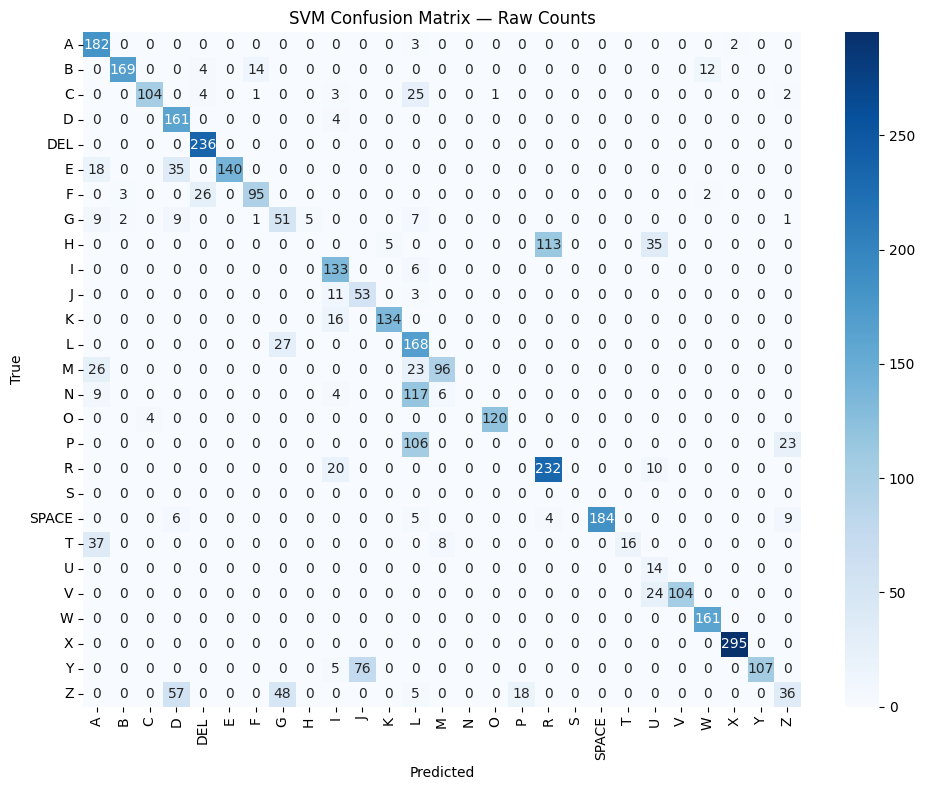

Saved normalized confusion matrix to: D:\5710\MajorProj\confusion_matrix_svm_norm.png


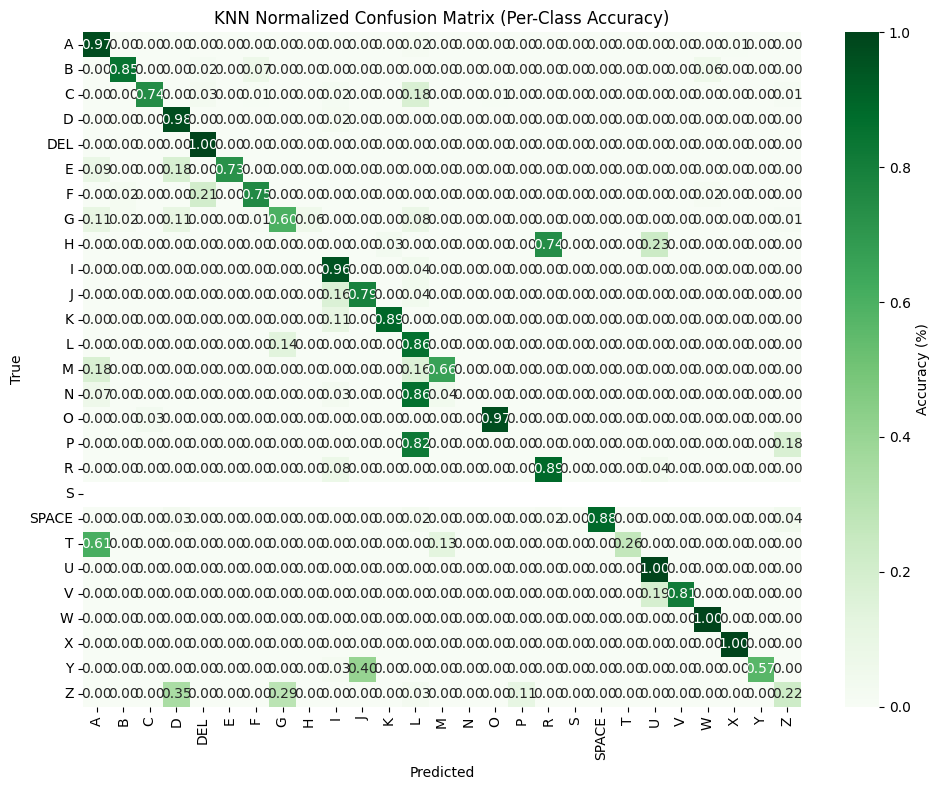

A        → 97.33%
B        → 84.92%
C        → 74.29%
D        → 97.58%
DEL      → 100.00%
E        → 72.54%
F        → 75.40%
G        → 60.00%
H        → 0.00%
I        → 95.68%
J        → 79.10%
K        → 89.33%
L        → 86.15%
M        → 66.21%
N        → 0.00%
O        → 96.77%
P        → 0.00%
R        → 88.55%
S        → nan%
SPACE    → 88.46%
T        → 26.23%
U        → 100.00%
V        → 81.25%
W        → 100.00%
X        → 100.00%
Y        → 56.91%
Z        → 21.95%

Mean class accuracy: nan%


In [ ]:
#run to test the perfomance of SVM model  


import os, sys, glob
from pathlib import Path
import cv2
import joblib
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# (Optional) prettier CM
try:
    import seaborn as sns
    USE_SEABORN = True
except Exception:
    USE_SEABORN = False

# ====== IMPORT YOUR OWN HELPERS ======
# Make sure these imports match your project structure
# e.g., from mypkg.features import FeatureCombiner
# ====== PATHS ======
TEST_ROOT = Path(r"D:/5710/MajorProj/test")           # test root with class subfolders A, B, C, D, ...
MODEL_PATH = Path(r"D:/5710/MajorProj/Models/svm_model.pkl")
OUT_CSV = Path(r"D:/5710/MajorProj/eval_predictions.csv")
CM_PNG = Path(r"D:/5710/MajorProj/confusion_matrix.png")

# ====== FEATURE ORDER (must match training) ======
FEATURE_ORDER = [
    "geo_angle_index_j1", "geo_angle_index_j2", "geo_angle_index_j3",
    "geo_angle_middle_j1", "geo_angle_middle_j2", "geo_angle_middle_j3",
    "geo_angle_pinky_j1", "geo_angle_pinky_j2", "geo_angle_pinky_j3",
    "geo_angle_ring_j1", "geo_angle_ring_j2", "geo_angle_ring_j3",
    "geo_angle_thumb_j1", "geo_angle_thumb_j2", "geo_angle_thumb_j3",
    "geo_palm_area",
    "geo_spread_idx_mid", "geo_spread_mid_ring", "geo_spread_ring_pink",
    "geo_z_max", "geo_z_mean", "geo_z_min", "geo_z_rng", "geo_z_std",
    "img_edge_density", "img_lap_var"
]

def iter_images(root: Path):
    """Yield (img_path, class_name) for images in class subfolders."""
    # Accept common image extensions
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        cls = class_dir.name
        for p in class_dir.rglob("*"):
            if p.suffix.lower() in exts:
                yield p, cls

def main():
    # ---- Load model
    svm_model = joblib.load(MODEL_PATH)

    # ---- Build class list from folders
    class_names = sorted([p.name for p in TEST_ROOT.iterdir() if p.is_dir()])
    if not class_names:
        print(f"[Error] No class folders found under: {TEST_ROOT}")
        sys.exit(1)
    print(f"Detected classes: {class_names}")

    # ---- MediaPipe Hands (static mode for images)
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.8,
        model_complexity=1
    )

    # ---- Your feature combiner
    combiner = FeatureCombiner(include_original63=False)

    y_true, y_pred, rows = [], [], []
    n_total, n_skipped, n_nohand = 0, 0, 0

    for img_path, true_cls in iter_images(TEST_ROOT):
        n_total += 1
        img = cv2.imread(str(img_path))
        if img is None:
            n_skipped += 1
            continue

        r = process_image_with_mediapipe(img, hands)
        if r is None:
            n_skipped += 1
            continue
        if r.get("n_hands", 0) == 0:
            n_nohand += 1
            continue

        # Take the first hand
        hinfo = r["hands"][0]
        row63 = np.array(hinfo["feature63"], dtype=np.float32)
        # shape (21,3)
        L = row63.reshape((21, 3))

        # Normalize like your snippet
        Lc, info = normalize_hand_orientation(
            L,
            method="basis",
            kabsch_with_scale=True,
            mirror_thumb=True
        )
        # Keep your z_zoomfactor logic (note: you multiplied X in your snippet)
        z_zoomfactor = 2.5
        Lc[:, 0] *= z_zoomfactor

        # Compute features
        feats = combiner.compute(img, Lc)

        # Reorder as a row vector
        feat_vec = np.array([feats.get(k, np.nan) for k in FEATURE_ORDER], dtype=np.float32).reshape(1, -1)

        # Predict
        pred = svm_model.predict(feat_vec)[0]

        y_true.append(true_cls)
        y_pred.append(pred)

        rows.append((str(img_path), true_cls, str(pred)))

    # ---- Report basic stats
    print(f"Total images: {n_total}, skipped: {n_skipped}, no-hand: {n_nohand}, used: {len(y_true)}")

    if len(y_true) == 0:
        print("[Error] No usable test images. Check your folders or preprocessing.")
        return

    # ---- Save predictions CSV
    import csv
    with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["image_path", "true_class", "predicted_class"])
        w.writerows(rows)
    print(f"Saved predictions to: {OUT_CSV}")

    # ---- Classification report
    # Ensure labels consistent & ordered
    labels = class_names
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))


    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Optional: output paths for both figures
    CM_RAW_PNG  = CM_PNG.with_name("confusion_matrix_svm_raw.png")
    CM_NORM_PNG = CM_PNG.with_name("confusion_matrix_svm_norm.png")

    # --- Plot raw confusion matrix ---
    plt.figure(figsize=(10, 8))
    if USE_SEABORN:
        import seaborn as sns
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names
        )
    else:
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.xticks(range(len(class_names)), class_names, rotation=45)
        plt.yticks(range(len(class_names)), class_names)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
        plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("SVM Confusion Matrix — Raw Counts")
    plt.tight_layout()
    plt.savefig(CM_RAW_PNG, dpi=200)
    print(f"Saved raw confusion matrix to: {CM_RAW_PNG}")
    plt.show()

    # --- Plot normalized accuracy matrix (per-class) ---
    plt.figure(figsize=(10, 8))
    if USE_SEABORN:
        import seaborn as sns
        sns.heatmap(
            cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Accuracy (%)'}  # note: values are 0–1; change label if you prefer 0–100
        )
    else:
        plt.imshow(cm_norm, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)
        plt.xticks(range(len(class_names)), class_names, rotation=45)
        plt.yticks(range(len(class_names)), class_names)
        for i in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
        cbar = plt.colorbar()
        cbar.set_label('Accuracy (%)')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("KNN Normalized Confusion Matrix (Per-Class Accuracy)")
    plt.tight_layout()
    plt.savefig(CM_NORM_PNG, dpi=200)
    print(f"Saved normalized confusion matrix to: {CM_NORM_PNG}")
    plt.show()

    # ---- Optional: print per-class accuracy like the upper style
    class_acc = np.diag(cm_norm)
    for lbl, acc in zip(class_names, class_acc):
        print(f"{lbl:<8s} → {acc*100:.2f}%")
    print(f"\nMean class accuracy: {class_acc.mean()*100:.2f}%")


    hands.close()

if __name__ == "__main__":
    main()
